# Evaluate how well the Harmondy batch correction worked using 

In [1]:
!date

Mon Nov 10 23:14:30 UTC 2025


#### import libraries and set notebook variables

In [2]:
import scanpy as sc
from sklearn.metrics import silhouette_score
from anndata import AnnData
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import warnings
warnings.simplefilter('ignore')

In [22]:
# variables and constants
cohort = 'aging'
DEBUG = True

# directories
wrk_dir = '/home/jupyter/data/ADRD_Brain_Aging'
quants_dir = f'{wrk_dir}/demux'
figures_dir = f'{wrk_dir}/figures'

# in files
in_h5ad = f'{quants_dir}/{cohort}.pegasus.leiden_085.subclustered.h5ad'

# out files
scib_results_file = f'{figures_dir}/scib_results_harmony.csv'

if DEBUG:
    print(f'{in_h5ad=}')
    print(f'{scib_results_file=}')

in_h5ad='/home/jupyter/data/ADRD_Brain_Aging/demux/aging.pegasus.leiden_085.subclustered.h5ad'
scib_results_file='/home/jupyter/data/ADRD_Brain_Aging/figures/scib_results_harmony.csv'


#### functions

In [9]:
def peek_anndata(adata: AnnData, message: str=None, verbose: bool=False):
    if not message is None and len(message) > 0:
        print(message)
    print(adata)
    if verbose:
        display(adata.obs.head())
        display(adata.var.head())

## read the anndata (h5ad) file

In [10]:
%%time
adata = sc.read_h5ad(in_h5ad)
peek_anndata(adata, 'loaded input anndata', DEBUG)

loaded input anndata
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds',

,pool_name,Sample_id,Tissue_source,Brain_region,Clinical_diagnosis,Age,Sex,donor_id,lane_num,Channel,...,n_counts,percent_mito,scale,Group,leiden_labels,anno,leiden_labels_085,new_anno,Age_group,broad_celltype
barcodekey,,,,,,,,,,,,,,,,,,,,,
AAACCCACAGTTGGTT-1,P001,Aging080,NIMH Human Brain Collection Core,Middle temporal gyrus,Healthy,21.5,Female,NHBCC-1187,1,Aging080,...,40076.0,0.197125,2.495321,one_group,6,Glutamatergic neuron LAMP5,6,ExN CUX2 LAMP5,young,ExN
AAACCCATCTCGCTTG-1,P001,Aging073,NIMH Human Brain Collection Core,Middle temporal gyrus,Healthy,64.3,Female,NHBCC-1119,1,Aging073,...,16716.0,0.424743,5.983008,one_group,6,Glutamatergic neuron LAMP5,6,ExN CUX2 LAMP5,old,ExN
AAACGAACACGGTAGA-1,P001,Aging095,NIMH Human Brain Collection Core,Middle temporal gyrus,Healthy,27.2,Male,NHBCC-1604,1,Aging095,...,4130.0,0.217918,24.213075,one_group,1,Oligodendrocyte,1,Oligodendrocyte-1,young,Oligodendrocyte
AAACGCTAGAACTCCT-1,P001,Aging073,NIMH Human Brain Collection Core,Middle temporal gyrus,Healthy,64.3,Female,NHBCC-1119,1,Aging073,...,36964.0,0.097392,2.705481,one_group,6,Glutamatergic neuron LAMP5,6,ExN CUX2 LAMP5,old,ExN
AAACGCTAGTCAGCCC-1,P001,Aging073,NIMH Human Brain Collection Core,Middle temporal gyrus,Healthy,64.3,Female,NHBCC-1119,1,Aging073,...,33798.0,0.278123,2.959018,one_group,6,Glutamatergic neuron LAMP5,6,ExN CUX2 LAMP5,old,ExN


,n_cells,percent_cells,robust,highly_variable_features,mean,var,hvf_loess,hvf_rank
featurekey,,,,,,,,
MIR1302-2HG,14,0.008336,False,False,0.000150,0.000293,0.000000,-1
OR4F5,10,0.005954,False,False,0.000100,0.000187,0.000000,-1
AL627309.1,2520,1.500491,True,False,0.028111,0.059149,0.065533,43514
AL627309.3,15,0.008931,False,False,0.000173,0.000399,0.000000,-1
AL627309.2,1,0.000595,False,False,0.000007,0.000008,0.000000,-1


CPU times: user 1.43 s, sys: 5.64 s, total: 7.08 s
Wall time: 7.09 s


### take a look at the cell counts by cell type

In [11]:
# get cell counts by 'categories'
categories = ['Brain_region', 'new_anno', 'leiden_labels_085']
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Brain_region
Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: count, dtype: int64
new_anno
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            11289
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
ExN RORB              1966
ExN LAMP5             1963
uncertain-3           1929
Ependymal             1853
Mural                 1293
Endothelial            953
Oligodendrocyte-3      806
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Radial Glia              0
Name: count, dtype: int64
leiden_labels_085
1

## Calculate silhouette score

In [16]:
%%time
sil_score = silhouette_score(adata.obsm['X_pca_harmony'], adata.obs['new_anno'])
print("Silhouette score after:", sil_score)
sil_score = silhouette_score(adata.obsm['X_pca'], adata.obs['new_anno'])
print("Silhouette score before:", sil_score)

Silhouette score after: 0.19709545
Silhouette score before: 0.19330893
CPU times: user 2h 7min 2s, sys: 2h 15min 10s, total: 4h 22min 13s
Wall time: 12min 2s


In [17]:
%%time
sil_score = silhouette_score(adata.obsm['X_pca_harmony'], adata.obs['pool_name'])
print("Silhouette score after:", sil_score)
sil_score = silhouette_score(adata.obsm['X_pca'], adata.obs['pool_name'])
print("Silhouette score before:", sil_score)

Silhouette score after: -0.08552128
Silhouette score before: 0.009827746
CPU times: user 2h 10min 31s, sys: 2h 15min 8s, total: 4h 25min 39s
Wall time: 14min 11s


In [12]:
%%time
sil_score = silhouette_score(adata.obsm['X_pca_harmony'], adata.obs['Sample_id'])
print("Silhouette score:", sil_score)

Silhouette score: -0.1913677155971527
CPU times: user 1h 13min 49s, sys: 1h 18min 8s, total: 2h 31min 58s
Wall time: 6min 46s


In [15]:
%%time
sil_score = silhouette_score(adata.obsm['X_pca_harmony'], adata.obs['Brain_region'])
print("Silhouette score:", sil_score)

Silhouette score: -0.017677471
CPU times: user 1h 5min 2s, sys: 1h 7min 59s, total: 2h 13min 1s
Wall time: 6min 55s


## Use Benchmarker to calculate multiple metrics including LISI

In [13]:
%%time
bm = Benchmarker(
    adata,
    batch_key='pool_name',
    label_key='new_anno',
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=['X_pca', 'X_pca_harmony'],
    n_jobs=24,
)

bm.prepare()
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:2025-11-10 23:31:20,104:jax._src.xla_bridge:794: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [22:21<08:01, 120.46s/it, Batch correction: kbet_per_label]

INFO     Astrocyte-GFAP-Hi consists of a single batch or is too small. Skip.                                       



Embeddings:  50%|█████     | 1/2 [24:31<24:31, 1471.08s/it]ch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [21:55<07:42, 115.54s/it, Batch correction: kbet_per_label]

INFO     Astrocyte-GFAP-Hi consists of a single batch or is too small. Skip.                                       



Embeddings: 100%|██████████| 2/2 [48:40<00:00, 1460.03s/it]ch correction: pcr_comparison]

                                                                                         

CPU times: user 3h 5min 4s, sys: 2h 7min 19s, total: 5h 12min 24s
Wall time: 54min 40s


### get the benchmark results

In [15]:
results = bm.get_results(min_max_scale=False)
display(results)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,BRAS,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_pca,0.658814,0.671349,0.369188,0.570085,1.0,0.628424,0.004924,0.131915,0.919904,0.0,0.337034,0.653887,0.527146
X_pca_harmony,0.664297,0.791296,0.564275,0.598548,1.0,0.868594,0.221916,0.337515,0.896943,0.5639,0.577774,0.723683,0.665319
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


## save the benchmark results

In [23]:
results.to_csv(scib_results_file)

## visualize the benchmark results

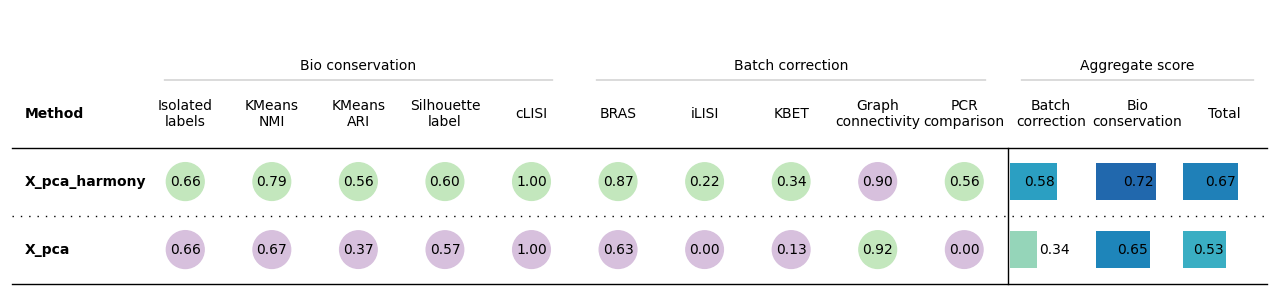

In [20]:
bm.plot_results_table(save_dir=figures_dir)

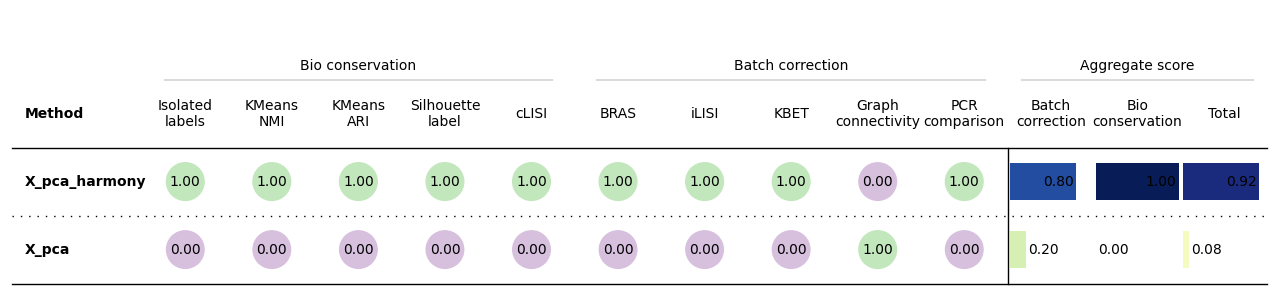

In [24]:
bm.plot_results_table(min_max_scale=True)

In [ ]:
!date